AML HW 3


  
    
    
Submitted by:

 Harguna Sood (hs3159)

 Siddhanth Vinay (sv2609)

In [0]:
!pip install xgboost
!pip install shap
!pip install category_encoders

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394112 sha256=bc79183ddcb12fd6650325071beedf511ac53472f7c6e443fcd0293112b298b7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import  make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn import tree
import graphviz

# Task 1

In [0]:
vehicles =  pd.read_csv("/Users/hargunasood/Downloads/vehicles.csv")
print(vehicles.shape)
print(vehicles.columns)

(539759, 25)
Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')


Dropping the following columns as it is quite clear that these features are not useful for prediction:  
- id: it is the 'id' of each entry in the data and has nothing to do with the price
- url: this feature does not provide any information related to attributes of the vehicle as it is just a website address
- region_url: this feature does not provide any information related to attributes of the vehicle as it is just a website address of the region. we can directly use the region feature for the similar purpose
- vin:  vehicle identification number is similar to 'id', in the sense that it allows for identification of different vehicles, but is not an attribute of the vehicle. Thus, does not judge the price of the vehicle
- image_url: this feature does not provide any information related to attributes of the vehicle as it is just a website address for the image of the vehicle. Until we are using the image of the vehicle to judge it's condition, which can be very complicated and will involve computer vision, it is not useful
- county: null column
- description: as directed in the question
- lat/long: similar information can be conveyed by region/state on a broader level (like binning lat/long)

Leakage of info: url and description - these can reveal the actual price of the vehicle

In [0]:
drop_cols = ["id", "url", "region_url", "vin", "image_url", "description", "county", "lat", "long"]
data = vehicles.drop(drop_cols, axis = 1)
data = data[data["price"]>0]
data = data.sample(frac = 0.2, random_state = 0, axis = 0)

Year as continuous

Text(0, 0.5, 'Price (log10)')

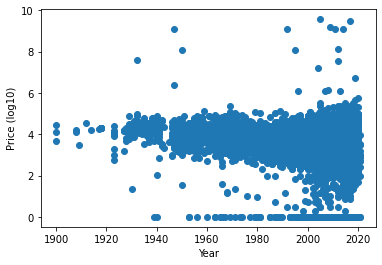

In [0]:
temp = data.copy()
temp = temp[(temp["year"]!=0) & (temp["price"]!=0) & (temp["price"].notna()) & (temp["year"].notna())]
plt.scatter(temp["year"], np.log10(temp["price"]))
plt.xlabel("Year")
plt.ylabel("Price (log10)")

Year as categorical

Text(0, 0.5, 'Average Price (log10)')

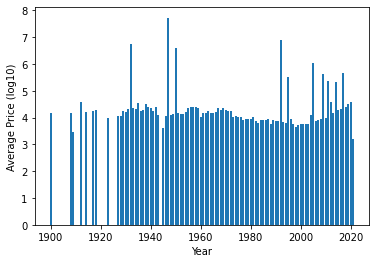

In [0]:
#average by year
temp = temp[["price", "year"]]

temp = temp.groupby("year").mean()

temp = temp.reset_index()

plt.bar(temp["year"], np.log10(temp["price"]))

plt.xlabel("Year")
plt.ylabel("Average Price (log10)")

Since we do not see any clear trends of price increase over the years, we will treat year as a categorical variable with target encoding.

Selected Features' visualisation:

high cardinality features: region, year, manufacturer, model, state  
low cardinality features: condition, cylinders, fuel, title_status, transmission, drive, size, type, paint_color


In [0]:
temp2 = data.copy()
temp2["price"] = np.log10(pd.Series(temp2["price"]))

Boxplots and histograms, category-wise (low cardinality features)

Condition

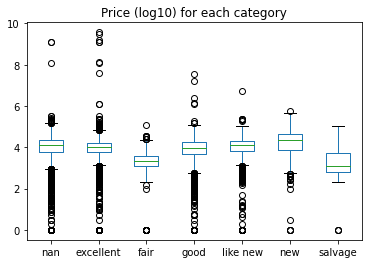

In [88]:
temp2.assign(index=temp2.groupby('condition').cumcount()).pivot('index','condition','price').plot(kind='box', title="Price (log10) for each category");

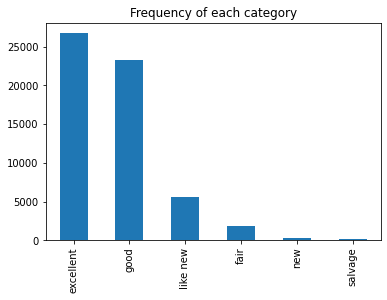

In [0]:
temp2["condition"].value_counts().plot(kind='bar', title="Frequency of each category");

Cylinders

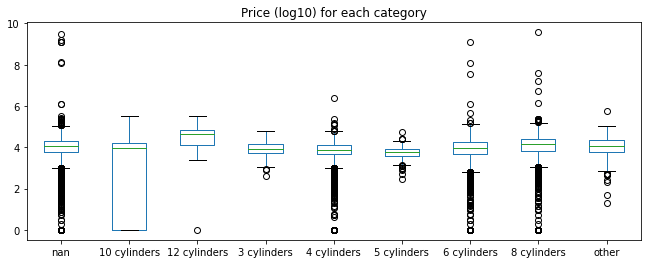

In [90]:
temp2.assign(index=temp2.groupby('cylinders').cumcount()).pivot('index','cylinders','price').plot(kind='box', figsize=(11,4), title="Price (log10) for each category");

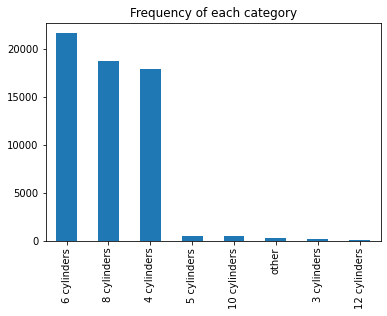

In [0]:
temp2["cylinders"].value_counts().plot(kind='bar', title="Frequency of each category");

Fuel

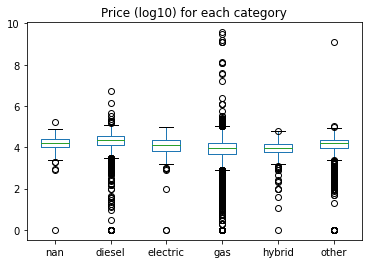

In [0]:
temp2.assign(index=temp2.groupby('fuel').cumcount()).pivot('index','fuel','price').plot(kind='box', title="Price (log10) for each category");

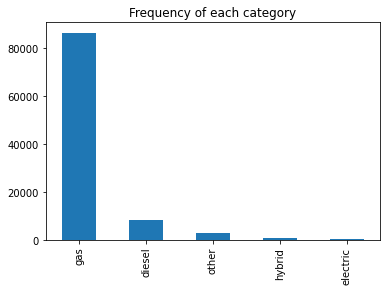

In [0]:
temp2["fuel"].value_counts().plot(kind='bar', title="Frequency of each category");

Title Status

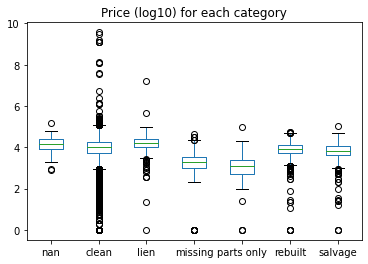

In [0]:
temp2.assign(index=temp2.groupby('title_status').cumcount()).pivot('index','title_status','price').plot(kind='box', title="Price (log10) for each category");

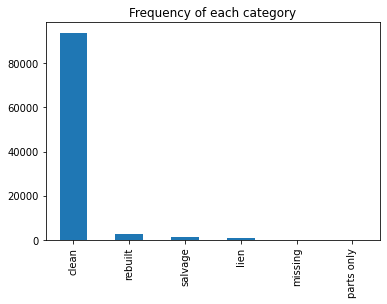

In [0]:
temp2["title_status"].value_counts().plot(kind='bar', title="Frequency of each category");

Transmission

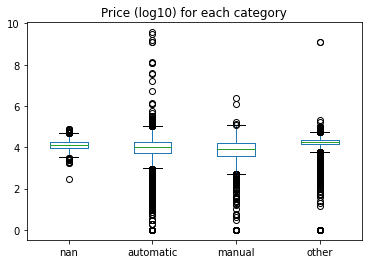

In [0]:
temp2.assign(index=temp2.groupby('transmission').cumcount()).pivot('index','transmission','price').plot(kind='box', title="Price (log10) for each category");

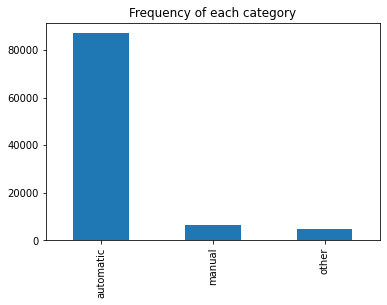

In [0]:
temp2["transmission"].value_counts().plot(kind='bar', title="Frequency of each category");

Drive

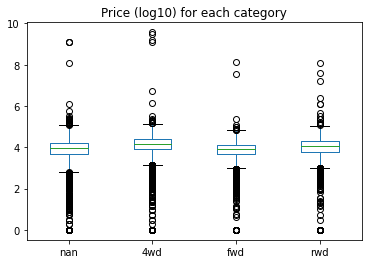

In [0]:
temp2.assign(index=temp2.groupby('drive').cumcount()).pivot('index','drive','price').plot(kind='box', title="Price (log10) for each category");

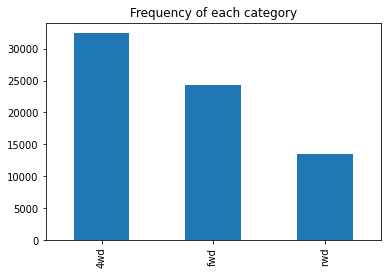

In [0]:
temp2["drive"].value_counts().plot(kind='bar', title="Frequency of each category");

 Size

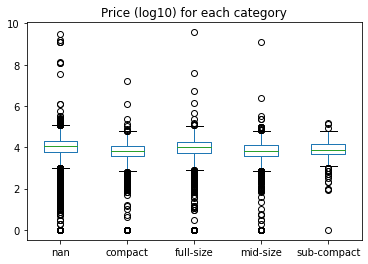

In [0]:
temp2.assign(index=temp2.groupby('size').cumcount()).pivot('index','size','price').plot(kind='box', title="Price (log10) for each category");

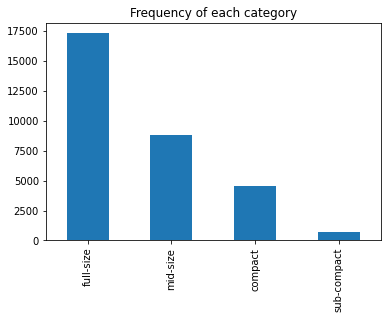

In [0]:
temp2["size"].value_counts().plot(kind='bar', title="Frequency of each category");

 Type

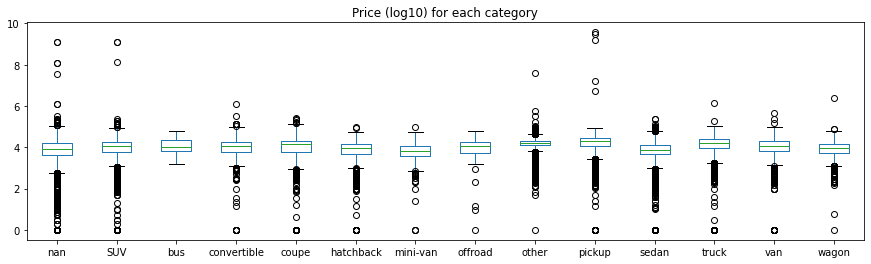

In [0]:
temp2.assign(index=temp2.groupby('type').cumcount()).pivot('index','type','price').plot(kind='box', figsize=(15,4), title="Price (log10) for each category");

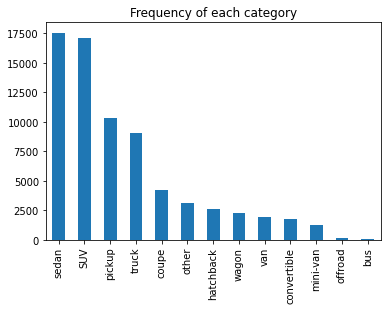

In [0]:
temp2["type"].value_counts().plot(kind='bar', title="Frequency of each category");

 Paint Color

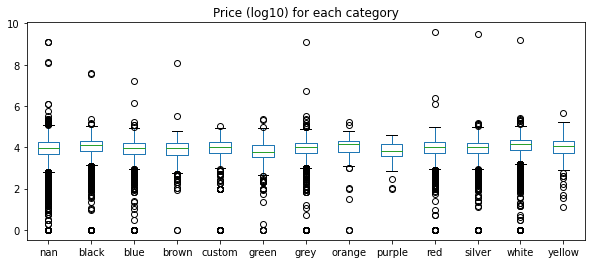

In [0]:
temp2.assign(index=temp2.groupby('paint_color').cumcount()).pivot('index','paint_color','price').plot(kind='box', figsize=(10,4), title="Price (log10) for each category");

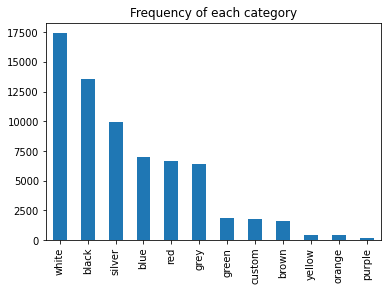

In [0]:
temp2["paint_color"].value_counts().plot(kind='bar', title="Frequency of each category");

Considering the feature shown above, we can see that there is a difference for each category, both in terms of average price and frequency. Thus, this might be helpful in predicting

Histogram and average price, category-wise (top 10 categories)



Manufacturer

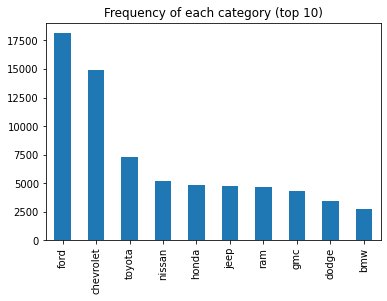

In [0]:
temp2["manufacturer"].value_counts()[:10].plot(kind='bar', title="Frequency of each category (top 10)");

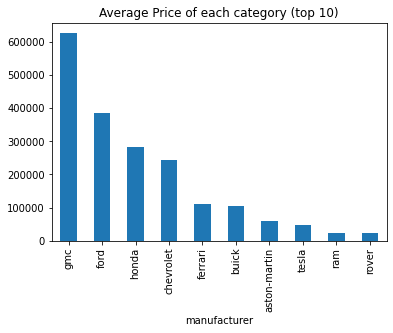

In [94]:
data.groupby("manufacturer", as_index=True)["price"].mean().sort_values(ascending=False)[:10].plot(kind="bar", title="Average Price of each category (top 10)");

Model

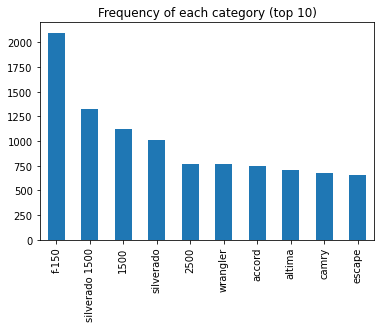

In [0]:
temp2["model"].value_counts()[:10].plot(kind='bar', title="Frequency of each category (top 10)");

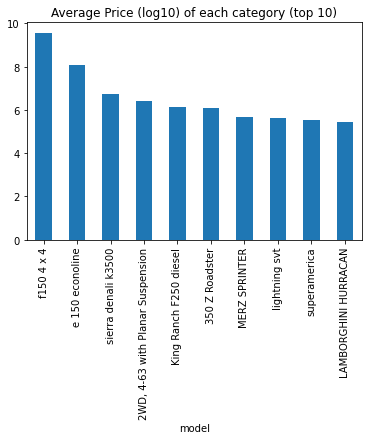

In [93]:
temp2.groupby("model", as_index=True)["price"].mean().sort_values(ascending=False)[:10].plot(kind="bar", title="Average Price (log10) of each category (top 10)");

Region

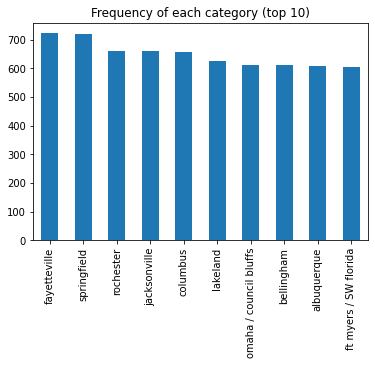

In [0]:
temp2["region"].value_counts()[:10].plot(kind='bar', title="Frequency of each category (top 10)");

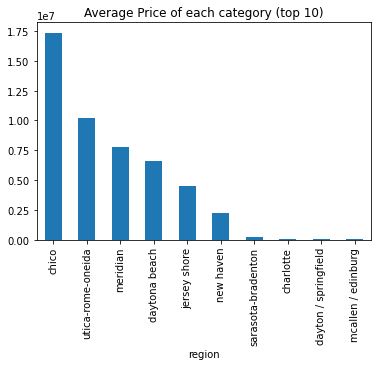

In [96]:
data.groupby("region", as_index=True)["price"].mean().sort_values(ascending=False)[:10].plot(kind="bar", title="Average Price of each category (top 10)");

State

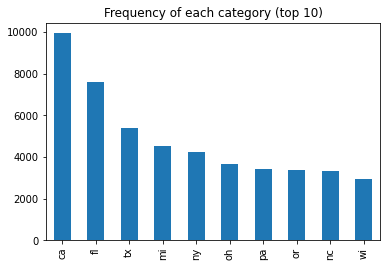

In [0]:
temp2["state"].value_counts()[:10].plot(kind='bar', title="Frequency of each category (top 10)");

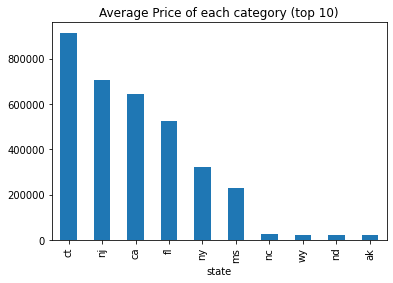

In [97]:
data.groupby("state", as_index=True)["price"].mean().sort_values(ascending=False)[:10].plot(kind="bar", title="Average Price of each category (top 10)");

Year

Shown above under "Year as category"

Given the above visualisations, we can see that there is a difference between frequency for each category and average price per category. Thus, these features might be hellpful in predictions

# Task 2

Price boxplots to identify outliers

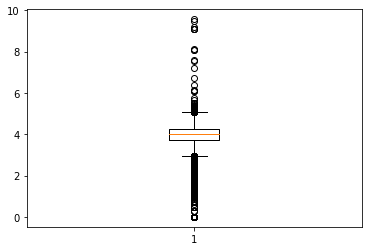

In [98]:
plt.boxplot(temp2["price"]);


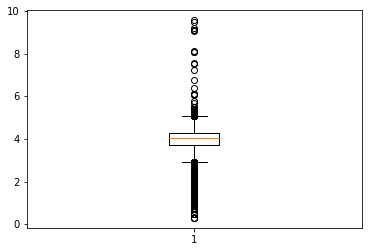

In [99]:
plt.boxplot(temp2[temp2["price"]>0]["price"]); # meaning price > 1


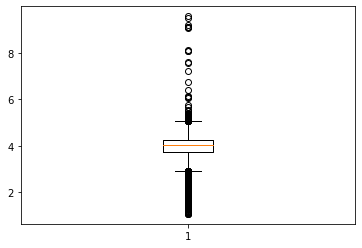

In [101]:
plt.boxplot(temp2[temp2["price"]>1]["price"]); # meaning price > 10

In [0]:
vehicles = vehicles[vehicles['price'] > 0]

(array([3.07100e+03, 4.62000e+02, 8.16000e+03, 1.63257e+05, 3.18186e+05,
        1.83000e+03, 2.70000e+01, 1.50000e+01, 1.80000e+01, 4.40000e+01]),
 array([0.        , 0.96329599, 1.92659197, 2.88988796, 3.85318394,
        4.81647993, 5.77977592, 6.7430719 , 7.70636789, 8.66966388,
        9.63295986]),
 <a list of 10 Patch objects>)

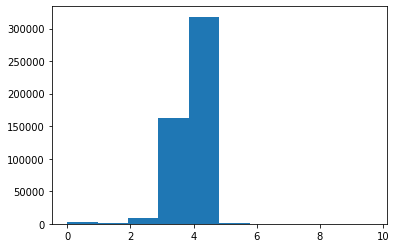

In [0]:
plt.hist(np.log10(vehicles['price']))

In [0]:
vehicles['log_price'] = np.log10(vehicles['price'])

Looking at the above box-plot and histogram of the price in log-space, we decide to remove outliers by filtering out prices having values < 10^2 or > 10^6.

In [0]:
vehicles = vehicles[vehicles['log_price'] > 2]
vehicles = vehicles[vehicles['log_price'] < 6]
vehicles = vehicles[vehicles['year'] > 0]

In [0]:
vehicles.shape

(489778, 26)

We consider a 20% random sample for training the model.

In [0]:
vehicles_sub = vehicles.sample(frac= 0.2,random_state=0)

In [0]:
vehicles_sub = vehicles_sub.drop(['id','url','region_url','vin','image_url','description','lat','long','county','log_price'],axis=1)

In [0]:
vehicles_sub.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
95256,houston,1000,2014.0,dodge,charger,excellent,6 cylinders,gas,108222.0,clean,other,rwd,compact,NaN,black,tx
116415,gainesville,7900,2013.0,chevrolet,silverado,excellent,NaN,gas,127120.0,clean,manual,fwd,NaN,pickup,white,fl
271598,columbus,29476,2019.0,ram,1500,excellent,NaN,gas,42909.0,clean,automatic,4wd,NaN,pickup,NaN,oh
433635,chicago,7500,2004.0,infiniti,g35 coupe,excellent,6 cylinders,gas,212000.0,clean,automatic,rwd,mid-size,coupe,black,il
300834,atlanta,4200,2006.0,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,NaN,NaN,truck,red,ga


We replace nans in the categorical variables as an 'Unknown category'

For the continuous variable odometer, we do median imputation on the missing values.

In [0]:
vehicles_sub = vehicles_sub.replace(np.nan,'Unknown')
vehicles_sub['odometer'] = vehicles_sub['odometer'].replace('Unknown',np.nan)
vehicles_sub['odometer'] = vehicles_sub['odometer'].replace(np.nan,vehicles_sub['odometer'].median(skipna = True))
vehicles_sub.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
95256,houston,1000,2014.0,dodge,charger,excellent,6 cylinders,gas,108222.0,clean,other,rwd,compact,Unknown,black,tx
116415,gainesville,7900,2013.0,chevrolet,silverado,excellent,Unknown,gas,127120.0,clean,manual,fwd,Unknown,pickup,white,fl
271598,columbus,29476,2019.0,ram,1500,excellent,Unknown,gas,42909.0,clean,automatic,4wd,Unknown,pickup,Unknown,oh
433635,chicago,7500,2004.0,infiniti,g35 coupe,excellent,6 cylinders,gas,212000.0,clean,automatic,rwd,mid-size,coupe,black,il
300834,atlanta,4200,2006.0,ford,f-150,good,6 cylinders,gas,95984.5,clean,automatic,Unknown,Unknown,truck,red,ga


In [0]:
X = vehicles_sub.drop('price',axis = 1)
y = vehicles_sub['price']

 We one-hot encode the low cardinality categorical variables.

In [0]:
X = pd.get_dummies(X,columns=['condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [0]:
#Continuous features without target encoded features.
cts_cols = [True for i in range(1)] + [False for i in range(69)]

#Continuous features before adding polynomial terms.
cts_cols_2 = [True for i in range(6)] + [False for i in range(69)]

#Continuous features after adding polynomial terms.
cts_cols_3 = [True for i in range(28)] + [False for i in range(69)]

 We use target encoding for the high cardinality categorical variables.

In [0]:
# Target Encoding
preprocess_1 = make_column_transformer(
    (ce.TargetEncoder(),['region','year','manufacturer','model','state']),remainder='passthrough')

# Polynomial transformation of continuous variables after target encoding.
preprocess_2 = make_column_transformer((PolynomialFeatures(degree=2),cts_cols_2),remainder='passthrough')

# Standard scaling of continuous variables without target encoding.
preprocess_3 = make_column_transformer((StandardScaler(),cts_cols),remainder='passthrough')

# Standard scaling of continuous variables without polynomial transformation.
preprocess_4 = make_column_transformer((StandardScaler(),cts_cols_2),remainder='passthrough')

# Standard scaling of variables with polynomial transformation
preprocess_5 = make_column_transformer((StandardScaler(),cts_cols_3),remainder='passthrough')

 For the baseline linear model, we will drop the columns to be target encoded and build a simple linear model.

In [0]:
X_train_sub = X_train.drop(['region','year','manufacturer','model','state'],axis=1)
X_test_sub = X_test.drop(['region','year','manufacturer','model','state'],axis=1)

In [0]:
pipeline_ols_baseline = make_pipeline(preprocess_3, LinearRegression())
scores_ols_baseline = cross_val_score(pipeline_ols_baseline,X_train_sub, y_train)
print("Mean Cross-Val R2 of OLS", np.mean(scores_ols_baseline))

Mean Cross-Val R2 of OLS -0.019819459293464358


In [0]:
pipeline_ols_baseline.fit(X_train_sub,y_train)
test_score_ols_baseline = pipeline_ols_baseline.score(X_test_sub,y_test)
print("R2 on Test Data",test_score_ols_baseline)

R2 on Test Data 0.2593607385626603


 We see that the initial baseline model performs poorly on the dataset, with a cross-val R2 of -0.01 and a test R2 of 0.26

# Task 3
 For 1.3 we will build two models and compare their performances -
 
 1) Including the variables to be target encoded.
 
 2) Not only doing target encoding, but also doing a degree 2 polynomial transformation on the target encoded variables and odometer (the only continuous variable in the original dataset). 

 Model without polynomial features

In [0]:
pipeline_ols_1 = make_pipeline(preprocess_1, preprocess_4, LinearRegression())
scores_ols_1 = cross_val_score(pipeline_ols_1,X_train, y_train)
print("Mean Cross-Val R2 of OLS", np.mean(scores_ols_1))

Mean Cross-Val R2 of OLS 0.32159375471953905


 Model with polynomial features

In [0]:
pipeline_ols_2 = make_pipeline(preprocess_1, preprocess_2, preprocess_5, LinearRegression())
scores_ols_2 = cross_val_score(pipeline_ols_2,X_train, y_train)
print("Mean Cross-Val R2 of OLS", np.mean(scores_ols_2))

Mean Cross-Val R2 of OLS -12.987715885880007



Looking at the cross validation R2 scores of the model without polynomial features and the model with polynomial features, it is clear that the model without polynomial features performs better on the dataset (possibly because of overfitting when using the polynomial features). Hence, we will consider the model without polynomial features as our enhanced linear model and evaluate it on the test set.

In [0]:
pipeline_ols_1.fit(X_train,y_train)
test_score_ols_1 = pipeline_ols_1.score(X_test,y_test)
print("R2 on Test Data",test_score_ols_1)

R2 on Test Data 0.4361175649433894


 We see that this model performs better than our initial baseline linear model on the test data, with an R2 of 0.43 as compared to an R2 of 0.26 in the initial baseline model.

# Task 4

For building a robust linear model - we have decided to use XGBoost for the following reasons - 

 1) State of the art model performance

2) Parallelization which yields faster results

3) No need to perform any feature scaling

4) Multiple one-hot encoded variables, hence makes logical sense to use a tree-based model as decision splitting becomes easier

5) We can use the SHAP package to test feature importances, which works only in combination with the XGBoost model.

In [0]:
pipeline_xgb = make_pipeline(preprocess_1, XGBRegressor(objective = 'reg:squarederror', n_estimators=100, n_threads = 16))
scores_xgb = cross_val_score(pipeline_xgb,X_train, y_train)
print("Mean Cross-Val R2 of XGBoost Regressor", np.mean(scores_xgb))

Mean Cross-Val R2 of XGBoost Regressor 0.6472762277017319


 We see that XGBoost yields a significantly better R2 of 0.64. We will now perform a simple grid-search on only the max_depth parameter of the XGBoost model as performing a grid search on more than one parameter is computationally infeasible.

In [0]:
pipe_xgb_grid = Pipeline([('target_encoding',preprocess_1), ('model', XGBRegressor(objective = 'reg:squarederror', n_estimators=100, n_threads = 16))])
param_grid_xgb = {'model__max_depth':[3,7,11]}
grid_xgb = GridSearchCV(pipe_xgb_grid, param_grid_xgb)
grid_xgb.fit(X_train, y_train)
print(grid_xgb.best_params_)
print("Best Score",grid_xgb.best_score_)

{'model__max_depth': 11}
Best Score 0.7228131663595396


 We see that an XGBoost model with a depth 11 has the best cross-val R2 of 0.72, hence we will build an XGBoost model with this depth and evaluate it on the test data and generate feature importances from this model.

In [0]:
pipeline_xgb_best = make_pipeline(preprocess_1, XGBRegressor(objective = 'reg:squarederror', n_estimators=100, n_threads = 16, max_depth= 11))
pipeline_xgb_best.fit(X_train,y_train)
test_score_xgb_best = pipeline_xgb_best.score(X_test,y_test)
print("R2 on Test Data",test_score_xgb_best)

R2 on Test Data 0.7158586388182716


 We see that this model performs very well on the test data, yielding an R2 of 0.716.

# Task 5

In [0]:
shap.initjs()


Since SHAP doesn't work with pipelines, we will have to build perform the pipeline step-by step.

Since running SHAP on a model with depth 11 is computationally infeasible, we build it on a model with depth 7 instead.

In [0]:
te = ce.TargetEncoder()
target_encoded_x = te.fit_transform(X_train.loc[:, ['region','year','manufacturer','model','state']], y_train)
x = X_train.drop(['region','year','manufacturer','model','state'], axis = 1)
x = pd.concat([x, target_encoded_x], axis =1)
xgb = XGBRegressor(objective = 'reg:squarederror', n_estimators=100, n_threads = 16, max_depth= 7)
xgb.fit(x, y_train)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


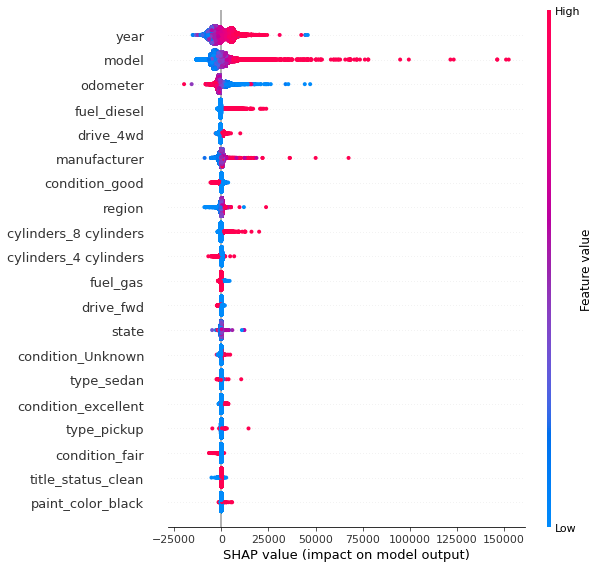

In [0]:
shap.summary_plot(shap_values, x)

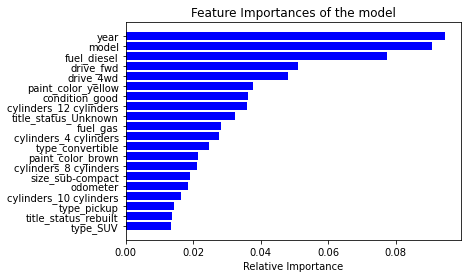

In [0]:
features = x.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)[-20:]
plt.title('Feature Importances of the model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


 Looking at the feature_importances_ of the XGBoost model and comparing them with the model important features according to SHAP values, we see that most of the features turn up in both the models, hence showing consistency across both the feature importances methods. 

In [0]:
X_train_top_10 = X_train[['year','model','odometer','fuel_diesel','drive_4wd','manufacturer','condition_good','region','cylinders_8 cylinders','cylinders_4 cylinders']]
X_test_top_10 = X_test[['year','model','odometer','fuel_diesel','drive_4wd','manufacturer','condition_good','region','cylinders_8 cylinders','cylinders_4 cylinders']]

In [0]:
preprocess_reduced = make_column_transformer(
    (ce.TargetEncoder(),['region','year','manufacturer','model']),remainder='passthrough')
pipeline_xgb_reduced = make_pipeline(preprocess_reduced, XGBRegressor(objective = 'reg:squarederror', n_estimators=100, n_threads = 16, max_depth= 11))
pipeline_xgb_reduced.fit(X_train_top_10,y_train)
scores_xgb_reduced = cross_val_score(pipeline_xgb_reduced,X_train_top_10, y_train)
print("Mean Cross-Val R2 of Reduced XGBoost Regressor", np.mean(scores_xgb_reduced))
test_score_xgb_reduced = pipeline_xgb_reduced.score(X_test_top_10,y_test)
print("R2 on Test Data",test_score_xgb_reduced)

Mean Cross-Val R2 of Reduced XGBoost Regressor 0.6933480313485776
R2 on Test Data 0.6885128758004257


 We see that the reduced model with only 10 features performs almost as well on the dataset as using all the features in the model, with a cross-val R2 of 0.693 as compared to 0.726 in the best model, and a test R2 of 0.688 as compared to a test R2 of 0.716 from the best model.

# Task 6
 To build an explainable model, we will pick the top 20 most important features according to their SHAP values and build a Random Forest Regressor with decision stumps to see if it can perform as well as the best model.

In [0]:
top_10_cols = ['odometer','year','model','manufacturer','region','fuel_diesel','drive_4wd','condition_good','cylinders_8 cylinders','cylinders_4 cylinders']

X_train_top_20 = X_train[top_10_cols]
X_test_top_20 = X_test[top_10_cols]

In [0]:
preprocess_explainable = make_column_transformer(
    (ce.TargetEncoder(),['year','model','manufacturer','state','region']),remainder='passthrough')
pipeline_dt_explainable = make_pipeline(preprocess_explainable, DecisionTreeRegressor(max_leaf_nodes=12))

pipeline_dt_explainable.fit(X_train_top_20,y_train)
scores_dt_explainable = cross_val_score(pipeline_dt_explainable,X_train_top_20, y_train)
print("Mean Cross-Val R2 of Explainable RF Regressor", np.mean(scores_dt_explainable))
test_score_dt_explainable = pipeline_dt_explainable.score(X_test_top_20,y_test)
print("R2 on Test Data",test_score_dt_explainable)

Mean Cross-Val R2 of Explainable RF Regressor 0.4599568208154531
R2 on Test Data 0.4605033565725051


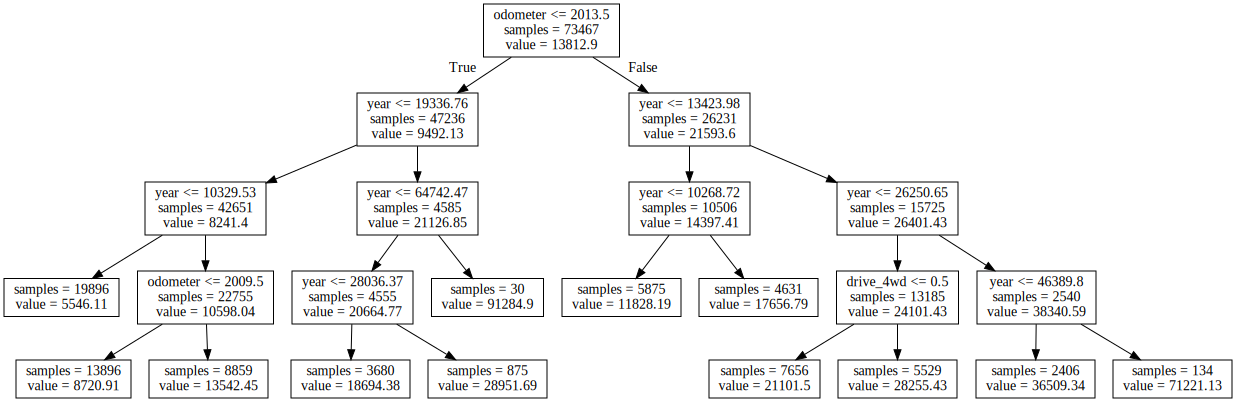

In [0]:
tree_data = tree.export_graphviz(pipeline_dt_explainable.get_params()['decisiontreeregressor'],feature_names=top_20_cols,impurity=False,precision=2)
graph = graphviz.Source(tree_data)
graph

 Thus, we have an explainable Decision Tree model, which performs well (R2 = 0.46 on test data), although not nearly as well as the best model which is far more complex with 100 XGBoost trees of max_depth 11.